In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import shutil
import pandas as pd

# Load the CSV file
df = pd.read_csv('/kaggle/input/leaf-disease/train.csv')

# Get the unique labels
labels = df['Label'].unique()

# Create a directory for each label
for label in labels:
    os.makedirs(os.path.join('/kaggle/working/', str(label)), exist_ok=True)

# Loop over the rows in the DataFrame
for index, row in df.iterrows():
    # Get the image name and its corresponding label
    image_name = row['Image']
    label = str(row['Label'])

    # Construct the source and destination paths
    source = os.path.join('/kaggle/input/leaf-disease/train', image_name)
    destination = os.path.join('/kaggle/working/', label, image_name)

    # Move the image
    shutil.copy(source, destination)
#     print(source)
#     print(destination)
#     print()

In [3]:
from sklearn.model_selection import train_test_split

# Specify the directory where your images are currently stored
source_dir = '/kaggle/working/'

# Specify the directories where you want to create the train and validation sets
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'

# Get the list of all labels
labels = [label for label in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, label))]

# Loop over the labels
for label in labels:
    # Get the list of all images for this label
    images = os.listdir(os.path.join(source_dir, label))
    
    # Check if the list of images is empty or contains only one image
    if len(images) < 2:
        print(f"Found less than 2 images for label {label}")
        
        if (len(images)!=0):
            for image in images:
                source = os.path.join(source_dir, label, image)
                destination = os.path.join(train_dir, label, image)
                shutil.move(source, destination)
            
            continue
        else:
            continue
    
    # Split the images into a training set and a validation set
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create directories for this label in the train and validation directories
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

    # Move the training images to the train directory
    for image in train_images:
        source = os.path.join(source_dir, label, image)
        destination = os.path.join(train_dir, label, image)
        shutil.move(source, destination)

    # Move the validation images to the validation directory
    for image in val_images:
        source = os.path.join(source_dir, label, image)
        destination = os.path.join(val_dir, label, image)
        shutil.move(source, destination)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found less than 2 images for label .virtual_documents


In [4]:
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'

In [5]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                           image_size=IMAGE_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode="categorical")

valid_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                           image_size=IMAGE_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           label_mode="categorical")

Found 10166 files belonging to 10 classes.
Found 2546 files belonging to 10 classes.


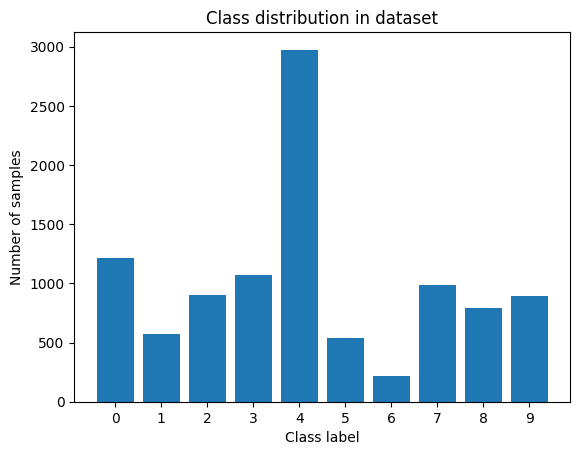

In [21]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = train_data.class_names
class_counts = np.zeros(len(class_labels))

for images, labels in train_data:
    label_indices = np.argmax(labels, axis=1)
    for label in label_indices:
        class_counts[label] += 1

plt.bar(class_labels, class_counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()


In [6]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [7]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

def Create_Model(Input_shape):
    
    Inputs = L.Input(shape=Input_shape) 
    
    x = L.Conv2D(64, 3, padding="same")(Inputs)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Conv2D(128, 3, padding="same")(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Conv2D(256, 3, padding="same")(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Conv2D(512, 3, padding="same")(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Flatten()(x)

    x = L.Dense(128, activation="relu")(x)
    Outputs = L.Dense(10, activation="softmax")(x)

    model = Model(Inputs, Outputs)
    return model

In [16]:
len(train_data), len(valid_data)

(318, 80)

In [10]:

model_1 = Create_Model((224, 224, 3))
    
print(model_1.input_shape)
print(model_1.output_shape)
print()
print(model_1.summary())

(None, 224, 224, 3)
(None, 10)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)         

In [11]:
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(lr=0.0005),
               metrics=["accuracy"])

history_1 = model_1.fit(train_data,
           epochs = 20,
           batch_size=32,
           steps_per_epoch = len(train_data),
           validation_data = valid_data,
           validation_steps = int(0.25*len(valid_data)))

Epoch 1/20
318/318 [==============================] - 44s 122ms/step - loss: 306.7748 - accuracy: 0.3086 - val_loss: 2.1416 - val_accuracy: 0.2984
Epoch 2/20
318/318 [==============================] - 38s 117ms/step - loss: 2.0933 - accuracy: 0.3110 - val_loss: 1.9687 - val_accuracy: 0.3031
Epoch 3/20
318/318 [==============================] - 38s 118ms/step - loss: 1.9488 - accuracy: 0.3092 - val_loss: 1.8911 - val_accuracy: 0.2937
Epoch 4/20
318/318 [==============================] - 37s 117ms/step - loss: 2.0256 - accuracy: 0.3005 - val_loss: 2.1566 - val_accuracy: 0.2719
Epoch 5/20
318/318 [==============================] - 37s 117ms/step - loss: 2.1197 - accuracy: 0.3010 - val_loss: 2.1239 - val_accuracy: 0.2875
Epoch 6/20
318/318 [==============================] - 38s 117ms/step - loss: 2.0892 - accuracy: 0.3008 - val_loss: 2.1167 - val_accuracy: 0.2937
Epoch 7/20
318/318 [==============================] - 38s 118ms/step - loss: 2.0932 - accuracy: 0.3009 - val_loss: 2.1000 - val_

In [13]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-05 06:54:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-05 06:54:46 (71.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [14]:
from helper_functions import plot_loss_curves

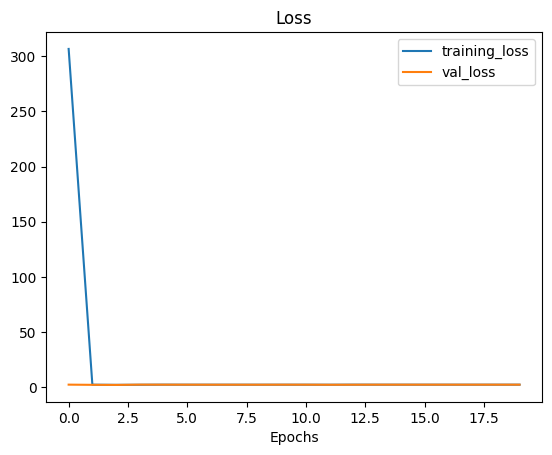

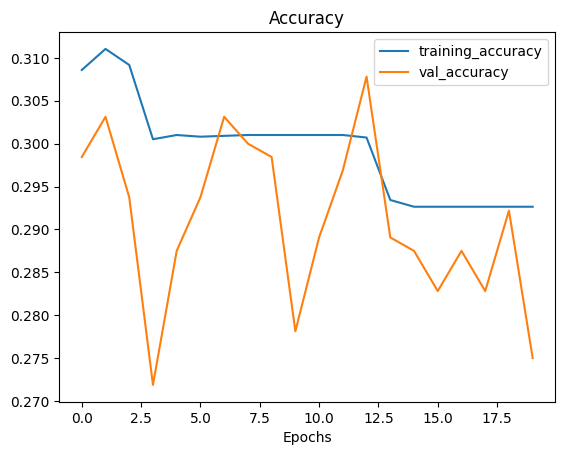

In [15]:
plot_loss_curves(history_1)

In [ ]:
a

In [ ]:
test_preds = model_1.predict(images)

In [ ]:
len(test_preds)

In [ ]:
test_preds.shape

In [ ]:
x = np.argmax(test_preds, axis=1)

In [ ]:
res=pd.DataFrame({'Label': x})
res.to_csv("/kaggle/working/sub.csv",index=False)